In [24]:
using Distributions
using LowRankApprox
using RCall
using CSV, Gadfly, DataFrames
include("../code/datasim.jl");
include("../code/likelihood.jl");
include("../code/mixEM.jl");
include("../code/mixSQP.jl");
include("../code/mixGD.jl");
include("../code/mixsqpnew.jl");
include("../code/REBayes.jl");

In [32]:
srand(2018);
z    = normtmixdatasim(round(Int,1e3));
sd   = autoselectmixsd(z,nv = 2000);
L    = normlikmatrix(z,sd = sd);
size(L)

(1000, 1000)

In [37]:
outem  = mixEM(L,maxiter = 10);
#outip  = REBayes(L);
outsqp = mixsqp(L, lowrank_criterion = "by_rtol", verbose = false);
outgd  = mixGD(L, alpha = 0.1, maxiter = 100);

In [45]:
@time xem, tem = mixEM(L,tol = 1e-6, maxiter = 500);
#@time xip, tip = REBayes(L);
@time outsqp   = mixsqp(L, lowrank_criterion = "by_rtol", verbose = false);
@time outsqp2  = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "none", verbose = false);
@time outgd    = mixGD(L, alpha = 0.2, maxiter = 20000);

  0.133551 seconds (10.26 k allocations: 115.593 MiB, 24.02% gc time)
  0.248479 seconds (57.75 k allocations: 502.774 MiB, 32.80% gc time)
  1.456249 seconds (56.64 k allocations: 949.756 MiB, 56.41% gc time)
 12.655129 seconds (2.66 M allocations: 1.833 GiB, 2.36% gc time)


In [39]:
fem   = mixobjective(L,xem);
#fip   = mixobjective(L,xip);
fsqp  = mixobjective(L,outsqp["x"]);
fsqp2 = mixobjective(L,outsqp2["x"]);
fgd   = mixobjective(L,outgd[1]);
fbest = minimum([fem fsqp fsqp2 fgd]);
@printf "Difference between EM and best solutions:  %0.2e\n" fem - fbest
#@printf "Difference between IP and best solutions:  %0.2e\n" fip - fbest
@printf "Difference between SQP and best solutions: %0.2e\n" fsqp - fbest
@printf "Difference between SQP2 and best solutions: %0.2e\n" fsqp2 - fbest
@printf "Difference between GD and best solutions: %0.2e\n" fgd - fbest

Difference between EM and best solutions:  1.11e+01
Difference between SQP and best solutions: 3.69e-13
Difference between SQP2 and best solutions: 0.00e+00
Difference between GD and best solutions: 4.91e-01


In [14]:
t = zeros(5,20); f = zeros(5,20);
for i = 1:10
    srand(2010 + i);
    z    = normtmixdatasim(round(Int,1e3));
    sd   = autoselectmixsd(z,nv = 2000);
    L    = normlikmatrix(z,sd = sd);
    t[1,i] = @elapsed outem = mixEM(L,tol = 1e-6, maxiter = 500);
    #t[2,i] = @elapsed outip = REBayes(L);
    t[3,i] = @elapsed outsqp   = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "qr", verbose = false);
    t[4,i] = @elapsed outsqp2  = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "none", verbose = false);
    t[5,i] = @elapsed outgd    = mixGD(L, alpha = 10, maxiter = 20000);
    fem   = mixobjective(L,outem[1]);
    #fip   = mixobjective(L,outip[1]);
    fsqp  = mixobjective(L,outsqp["x"]);
    fsqp2 = mixobjective(L,outsqp2["x"]);
    fgd   = mixobjective(L,outgd[1]);
    fbest = minimum([fem fsqp fsqp2 fgd]);
    @printf "Difference between EM and best solutions:  %0.2e\n" fem - fbest
    #@printf "Difference between IP and best solutions:  %0.2e\n" fip - fbest
    @printf "Difference between SQP and best solutions: %0.2e\n" fsqp - fbest
    @printf "Difference between SQP2 and best solutions: %0.2e\n" fsqp2 - fbest
    @printf "Difference between GD and best solutions: %0.2e\n" fgd - fbest
    f[1,i] = copy(fem);
    #f[2,i] = copy(fip);
    f[3,i] = copy(fsqp);
    f[4,i] = copy(fsqp2);
    f[5,i] = copy(fgd);
end

Difference between EM and best solutions:  6.23e-01
Difference between SQP and best solutions: 3.92e+00
Difference between SQP2 and best solutions: 3.92e+00
Difference between GD and best solutions: 0.00e+00


In [9]:
df1  = DataFrame(obj = [outem[2];outgd[2];outsqp["obj"];outsqp2["obj"]],
    time = [cumsum(outem[end]); cumsum([0;outgd[end][2:end]]);
        cumsum([0;outsqp["timing"][2:end]]); cumsum([0;outsqp2["timing"][2:end]])],
    method = [repeat(["EM"],length(outem[2]));repeat(["PGD"],length(outgd[2]));
            repeat(["mixSQP (QR)"],length(outsqp["timing"]));repeat(["mixSQP (noapprox)"],length(outsqp2["timing"]))]);
df1[:robj] = df1[:obj] - minimum(df1[:obj]) + 1e-12;

In [10]:
CSV.write("simcompare4.csv", df1, delim = ',')

CSV.Sink{Void,DataType}(    CSV.Options:
        delim: ','
        quotechar: '"'
        escapechar: '\\'
        missingstring: ""
        dateformat: nothing
        decimal: '.'
        truestring: 'true'
        falsestring: 'false'
        internstrings: true, IOBuffer(data=UInt8[...], readable=true, writable=true, seekable=true, append=false, size=0, maxsize=Inf, ptr=1, mark=-1), "data.csv", 21, true, String["obj", "time", "method", "robj"], 4, false, Val{false})

In [64]:
t = zeros(5,20); f = zeros(5,20);
    i = 1
    nv = 2000;
    srand(2018);
    z    = normtmixdatasim(round(Int,1000));
    sd   = autoselectmixsd(z,nv = nv);
    L    = normlikmatrix(z,sd = sd);
    t[1,i] = @elapsed outem = mixEM(L,tol = 1e-6, maxiter = 2000);
    t[2,i] = @elapsed outip = REBayes(L);
    t[3,i] = @elapsed outsqp   = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "qr", verbose = false);
    t[4,i] = @elapsed outsqp2  = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "none", verbose = false);
    t[5,i] = @elapsed outgd    = mixGD(L, alpha = 1, maxiter = 4000, formulation = "square");
    fem   = mixobjective(L,outem[1]);
    fip   = mixobjective(L,outip[1]);
    fsqp  = mixobjective(L,outsqp["x"]);
    fsqp2 = mixobjective(L,outsqp2["x"]);
    fgd   = mixobjective(L,outgd[1]);
    fbest = minimum([fem fip fsqp fsqp2 fgd]);
    @printf "Difference between EM and best solutions:  %0.2e\n" fem - fbest
    @printf "Difference between IP and best solutions:  %0.2e\n" fip - fbest
    @printf "Difference between SQP and best solutions: %0.2e\n" fsqp - fbest
    @printf "Difference between SQP2 and best solutions: %0.2e\n" fsqp2 - fbest
    @printf "Difference between GD and best solutions: %0.2e\n" fgd - fbest
    f[1,i] = copy(fem);
    f[2,i] = copy(fip);
    f[3,i] = copy(fsqp);
    f[4,i] = copy(fsqp2)
    f[5,i] = copy(fgd);

Difference between EM and best solutions:  1.92e+00
Difference between IP and best solutions:  2.61e-11
Difference between SQP and best solutions: 8.19e-12
Difference between SQP2 and best solutions: 0.00e+00
Difference between GD and best solutions: 1.03e+00


In [78]:
df2  = DataFrame(obj = [outem[2];outgd[2];outsqp["obj"];outsqp2["obj"]],
    time = [cumsum(outem[end]); cumsum([0;outgd[end][2:end]]);
        cumsum([0;outsqp["timing"][2:end]]); cumsum([0;outsqp2["timing"][2:end]])],
    method = [repeat(["EM"],length(outem[2]));repeat(["PGD"],length(outgd[2]));
            repeat(["mixSQP (noapprox)"],length(outsqp["timing"]));repeat(["mixSQP"],length(outsqp2["timing"]))]);
df2[:robj] = df2[:obj] - minimum(df2[:obj]) + 1e-12;

In [83]:
t = zeros(5,20); f = zeros(5,20);
    i = 1
    nv = 400;
    srand(2019);
    z    = normtmixdatasim(round(Int,1e4));
    sd   = autoselectmixsd(z,nv = nv);
    L    = normlikmatrix(z,sd = sd);
    t[1,i] = @elapsed outem = mixEM(L,tol = 1e-6, maxiter = 2000);
    t[2,i] = @elapsed outip = REBayes(L);
    t[3,i] = @elapsed outsqp   = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "qr", verbose = false);
    t[4,i] = @elapsed outsqp2  = mixsqp(L, lowrank_criterion = "by_rtol", lowrank_method = "none", verbose = false);
    t[5,i] = @elapsed outgd    = mixGD(L, alpha = 1, maxiter = 4000, formulation = "square");
    fem   = mixobjective(L,outem[1]);
    fip   = mixobjective(L,outip[1]);
    fsqp  = mixobjective(L,outsqp["x"]);
    fsqp2 = mixobjective(L,outsqp2["x"]);
    fgd   = mixobjective(L,outgd[1]);
    fbest = minimum([fem fip fsqp fsqp2 fgd]);
    @printf "Difference between EM and best solutions:  %0.2e\n" fem - fbest
    @printf "Difference between IP and best solutions:  %0.2e\n" fip - fbest
    @printf "Difference between SQP and best solutions: %0.2e\n" fsqp - fbest
    @printf "Difference between SQP2 and best solutions: %0.2e\n" fsqp2 - fbest
    @printf "Difference between GD and best solutions: %0.2e\n" fgd - fbest
    f[1,i] = copy(fem);
    f[2,i] = copy(fip);
    f[3,i] = copy(fsqp);
    f[4,i] = copy(fsqp2)
    f[5,i] = copy(fgd);

Difference between EM and best solutions:  1.97e+00
Difference between IP and best solutions:  1.23e-02
Difference between SQP and best solutions: 0.00e+00
Difference between SQP2 and best solutions: 2.74e-10
Difference between GD and best solutions: 1.10e+00


In [84]:
df3  = DataFrame(obj = [outem[2];outgd[2];outsqp["obj"];outsqp2["obj"]],
    time = [cumsum(outem[end]); cumsum([0;outgd[end][2:end]]);
        cumsum([0;outsqp["timing"][2:end]]); cumsum([0;outsqp2["timing"][2:end]])],
    method = [repeat(["EM"],length(outem[2]));repeat(["PGD"],length(outgd[2]));
            repeat(["mixSQP (noapprox)"],length(outsqp["timing"]));repeat(["mixSQP"],length(outsqp2["timing"]))]);
df3[:robj] = df3[:obj] - minimum(df3[:obj]) + 1e-12;

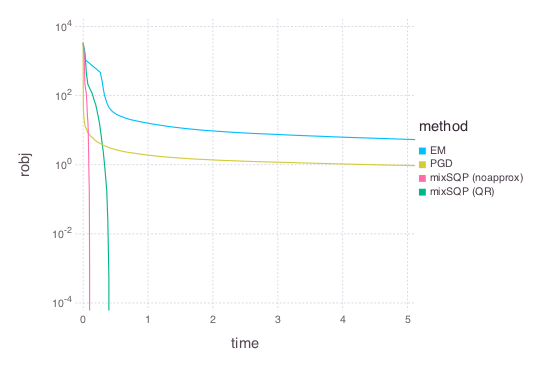

In [133]:
Gadfly.plot(df1, x = :time, y = :robj, color = :method, Geom.line,
            Scale.y_log10, Coord.Cartesian(xmax = 5, ymin = -4, ymax = 4))

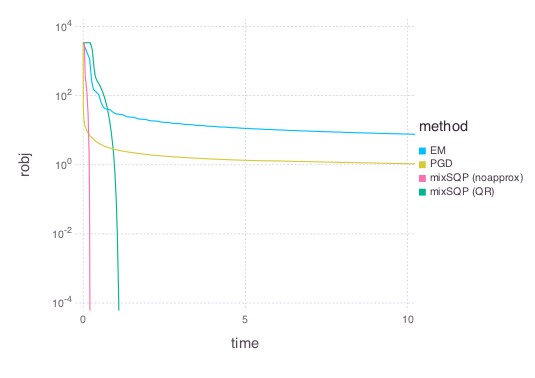

In [132]:
Gadfly.plot(df2, x = :time, y = :robj, color = :method, Geom.line,
            Scale.y_log10, Coord.Cartesian(xmax = 10, ymin = -4, ymax = 4))

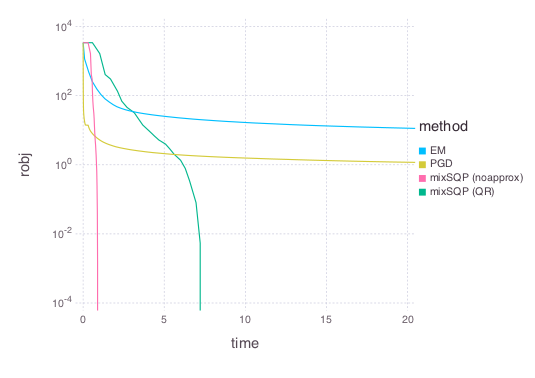

In [138]:
Gadfly.plot(df3, x = :time, y = :robj, color = :method, Geom.line,
            Scale.y_log10, Coord.Cartesian(xmax = 20, ymin = -4, ymax = 4))

In [96]:
data1          = CSV.read("../data/comparison.txt", delim = ',');
data1[:method] = repeat(["mixEM";"KWDual";"mix-SQP (approx)";"mix-SQP (no-approx)"], outer = 20);
t              = Matrix{Float64}(reshape(data1[:t],4,20)');
f              = Matrix{Float64}(reshape(data1[:f],4,20)');

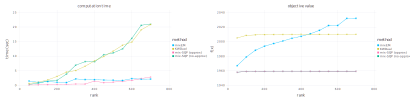

In [95]:
set_default_plot_size(41cm, 10.5cm)
p1 = Gadfly.plot(pdat, x = :m, y = :t, color = :method, shape = :method, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("time (sec)"),
                Guide.title("computation time"))
p2 = Gadfly.plot(pdat, x = :m, y = :f, color = :method, shape = :method, Geom.line, Geom.point,
                Guide.xlabel("rank"), Guide.ylabel("f(x)"),
                Guide.title("objective value"))
F  = hstack(p1,p2);
draw(PDF("fig3.pdf"), F)
F